# Paper Scenarios

Developed by Siobhan Powell, 2021;
Updated March 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import numpy as np
import pickle
import time

In [2]:
from speech_classes import SPEECh
from speech_classes import SPEEChGeneralConfiguration
from speech_classes import LoadProfile
from speech_classes import Plotting
from speech_classes import DataSetConfigurations

In [29]:
for scenario_name in ['UniversalHome', 'HighHome', 'LowHome_HighWork', 'LowHome_LowWork']:

    data = DataSetConfigurations(data_set='CP')
    speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
    speech.pa_ih(scenario=scenario_name) # define the access scenario
    if speech.pdih_data is None:
        speech.pdih_data = pd.read_csv(speech.data.folder + 'pdih_us_counties.csv', index_col=0)
    speech.pb_i()
    speech.pe_bd()
    local_df = speech.pdih_data[speech.pdih_data['State'].isin(['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ'])]
    local_df = local_df.rename(columns={'P_LowIncome': 'I_0', 'P_MedIncome': 'I_1', 'P_HighIncome': 'I_2'})
    local_df['H_0'] = local_df['P_Other']
    local_df['H_1'] = local_df['P_LargeApt']
    local_df['H_2'] = local_df['P_SmallApt']
    local_df['H_3'] = local_df['P_House_Attached']
    local_df['H_4'] = local_df['P_House_Detached']
    i_inds = ['I_'+str(i) for i in range(3)]
    h_inds = ['H_'+str(i) for i in range(5)]
    pa = 0*speech.pa_ih_data[speech.pa_ih_data.columns[0]]
    for i in range(len(i_inds)):
        for j in range(len(h_inds)):
            pa += local_df[i_inds[i]].values[0] * speech.pa_ih_data['I_'+str(int(i))+'_'+h_inds[j]] * local_df[h_inds[j]].values[0]
    print('---'*20)
    print(scenario_name)
    print('Fraction with SFH:', pa.loc[['work_paid_home_l2', 'work_free_home_l2', 'work_0_home_l2']].sum())
    print('Fraction with MUD:', pa.loc[['work_paid_home_mud', 'work_free_home_mud', 'work_0_home_mud']].sum())
    print('Fraction without any home charging: ', pa.loc[['work_paid_home_0', 'work_free_home_0', 'work_0_home_0']].sum())

------------------------------------------------------------
UniversalHome
Fraction with SFH: 0.804507
Fraction with MUD: 0.19549300000000003
Fraction without any home charging:  0.0
------------------------------------------------------------
HighHome
Fraction with SFH: 0.649117529077329
Fraction with MUD: 0.066150046087127
Fraction without any home charging:  0.284732424835544
------------------------------------------------------------
LowHome_HighWork
Fraction with SFH: 0.239164919096304
Fraction with MUD: 0.029192198771341
Fraction without any home charging:  0.731642882132355
------------------------------------------------------------
LowHome_LowWork
Fraction with SFH: 0.23916491909630402
Fraction with MUD: 0.029192198771341
Fraction without any home charging:  0.7316428821323551


In [3]:
data = DataSetConfigurations(data_set='CP')
speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=['OR'])
speech.pa_ih(scenario='HighHome') # define the access scenario
speech.pg_multiple_regions(region_type='State', region_value_list=['OR'])

In [9]:
speech.pdih_data[speech.pdih_data['State'].isin(['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ'])]['# Total Population, 2019 [Estimated]'].sum()

75085900

In [3]:
def plot(load_segments_array, load_segments_dict, data, save_str=None):
    
    x = (1/60)*np.arange(0, 1440)
    mark = np.zeros(np.shape(x))
    scaling = 1 / 1000
    unit = 'MW'
    if np.max(scaling * np.sum(load_segments_array, axis=1)) > 1000:
        scaling = (1 / 1000) * (1 / 1000)
        unit = 'GW'
    plt.figure(figsize=(8, 5))
    for key, val in load_segments_dict.items():
        plt.plot(x, scaling * (mark + val), color=data.colours[key])
        plt.fill_between(x, scaling * mark, scaling * (mark + val), label=key, color=data.colours[key])
        mark += val
    plt.plot(x, scaling * mark, 'k')
    plt.legend(fontsize=12, loc='upper left')
    plt.xlim([0, np.max(x)])
    plt.ylim([0, 1.1 * np.max(scaling * mark)])
    plt.ylabel(unit, fontsize=14)
    plt.xlabel('Hour', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    if save_str is not None:
        plt.savefig(save_str, bbox_inches='tight')
    plt.show()
    
    return

In [36]:
def run_100p_wecc(scenario_name, remove_timers, utility_region, save_string, date, tz_aware=True):
    
    wecc_tot_evs = 0
    state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
    time_zones = {'CA':0, 'OR':0, 'WA':0, 'ID':1, 'MT':1, 'WY':1, 'NV':0, 'UT':1, 'CO':1, 'NM':1, 'AZ':1}
    state_results = {}
    total_load_dict = {key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']}
    total_load_segments = np.zeros((1440, 6))
    for state in state_list:
        print('----------'+state+'----------')
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario=scenario_name) # define the access scenario
        speech.pg_multiple_regions(region_type='State', region_value_list=[state])
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekday')
        state_results[state] = {'Speech':speech, 'Config':config}
        if tz_aware:
            if time_zones[state] == 0:
                for key in total_load_dict.keys():
                    total_load_dict[key] += config.total_load_dict[key]
                total_load_segments += config.total_load_segments
            else:
                # Put into California time
                for key in total_load_dict.keys():
                    tmp = np.copy(config.total_load_dict[key])
                    tmp2 = np.zeros((1440,))
                    tmp2[np.arange(0, 1440-60)] = tmp[np.arange(60, 1440)]
                    tmp2[np.arange(1440-60, 1440)] = tmp[np.arange(0, 60)]
                    total_load_dict[key] += np.copy(tmp2)
                tmp = np.copy(config.total_load_segments)
                tmp2 = np.zeros((1440,6))
                tmp2[np.arange(0, 1440-60), :] = tmp[np.arange(60, 1440), :]
                tmp2[np.arange(1440-60, 1440), :] = tmp[np.arange(0, 60), :]
                total_load_segments += np.copy(tmp2)
        else:
            for key in total_load_dict.keys():
                total_load_dict[key] += config.total_load_dict[key]
            total_load_segments += config.total_load_segments
        print('Total EVs: ', config.num_total_drivers)
        wecc_tot_evs += config.num_total_drivers # aggregate states to wecc

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_'+str(state)+'_'+date+'.csv')
    pd.DataFrame(total_load_dict).to_csv('Outputs/'+save_string+'_WECC_'+date+'.csv')
    plot(total_load_segments, total_load_dict, data, 'Outputs/'+save_string+'_WECC_'+date+'.pdf')
    try:
        plot(total_load_segments, total_load_dict, data, 'Outputs/'+save_string+'_WECC_'+date+'.pdf')
    except:
        print('Error in plotting.')
    print('Total EVs in WECC: ', wecc_tot_evs)

    
    state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
    state_results = {}
    total_load_dict = {key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']}
    total_load_segments = np.zeros((1440, 6))
    for state in state_list:
        print('----------'+state+'----------')
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario=scenario_name) # define the access scenario
        speech.pg_multiple_regions(region_type='State', region_value_list=[state])
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekend')
        state_results[state] = {'Speech':speech, 'Config':config}
        if tz_aware:
            if time_zones[state] == 0:
                for key in total_load_dict.keys():
                    total_load_dict[key] += config.total_load_dict[key] 
                total_load_segments += config.total_load_segments # aggregate states to wecc
            else:
                # Put into California time
                for key in total_load_dict.keys():
                    tmp = np.copy(config.total_load_dict[key])
                    tmp2 = np.zeros((1440,))
                    tmp2[np.arange(0, 1440-60)] = tmp[np.arange(60, 1440)]
                    tmp2[np.arange(1440-60, 1440)] = tmp[np.arange(0, 60)]
                    total_load_dict[key] += np.copy(tmp2)
                tmp = np.copy(config.total_load_segments)
                tmp2 = np.zeros((1440,6))
                tmp2[np.arange(0, 1440-60), :] = tmp[np.arange(60, 1440), :]
                tmp2[np.arange(1440-60, 1440), :] = tmp[np.arange(0, 60), :]
                total_load_segments += np.copy(tmp2)
        else:
            for key in total_load_dict.keys():
                total_load_dict[key] += config.total_load_dict[key] 
            total_load_segments += config.total_load_segments # aggregate states to wecc
        print('Total EVs: ', config.num_total_drivers)

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_weekend_'+str(state)+'_'+date+'.csv')
    pd.DataFrame(total_load_dict).to_csv('Outputs/'+save_string+'_weekend_WECC_'+date+'.csv')
    
    return

# Main Scenarios

----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


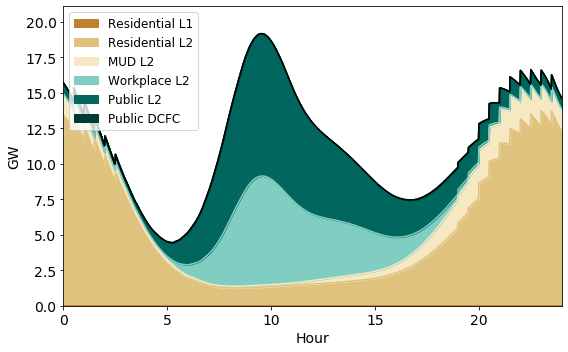

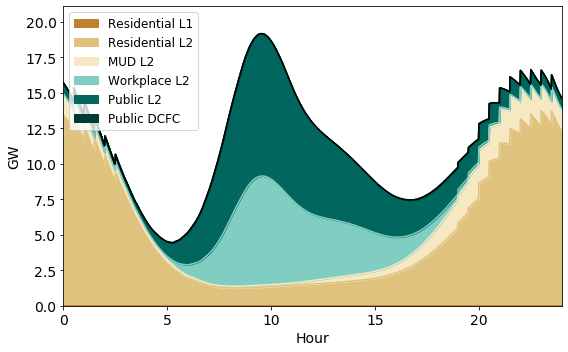

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


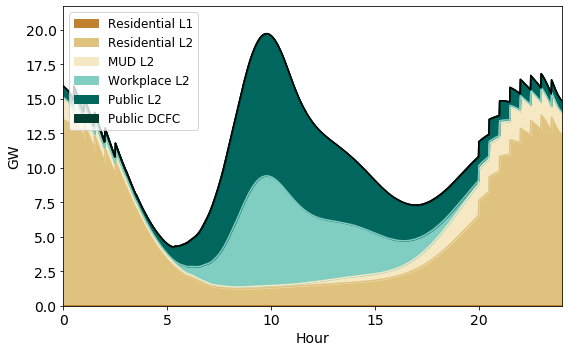

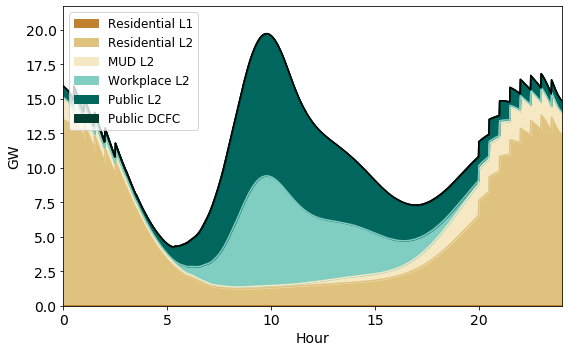

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


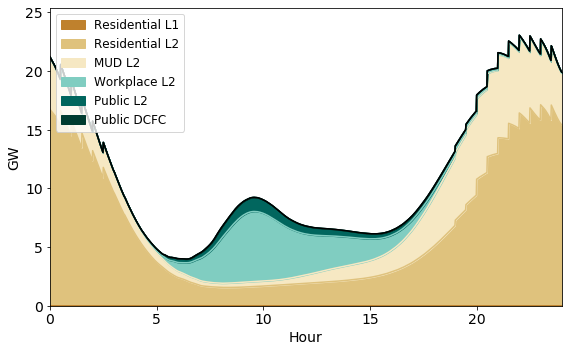

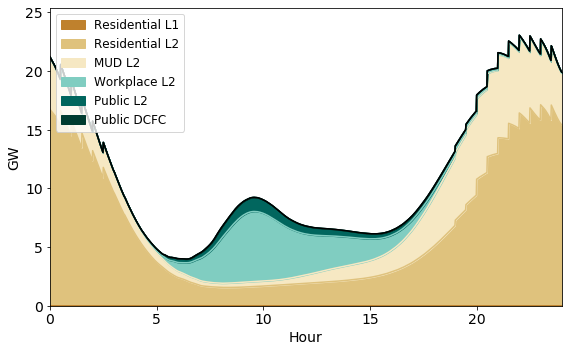

Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


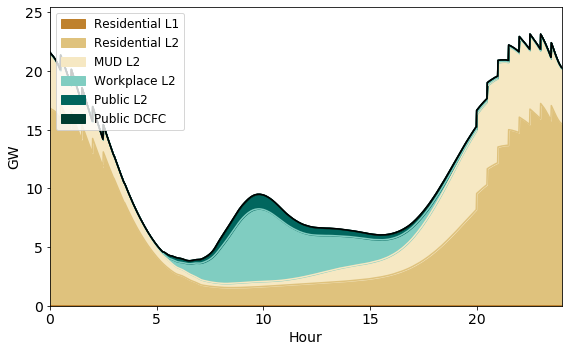

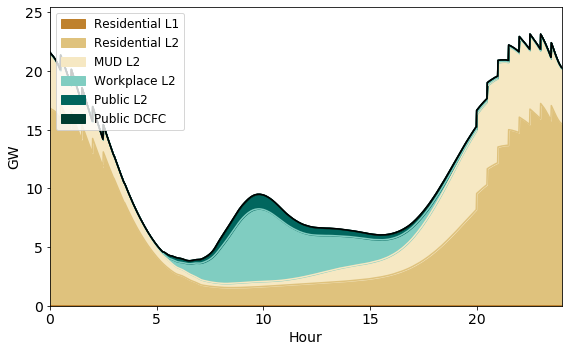

Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


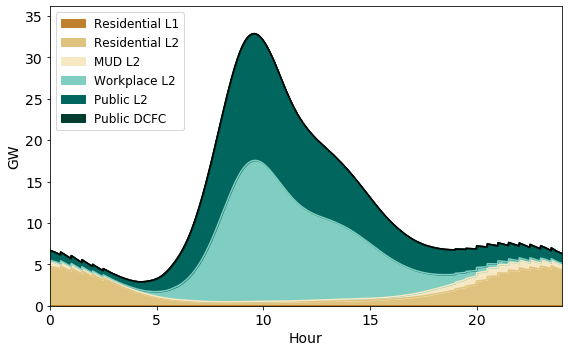

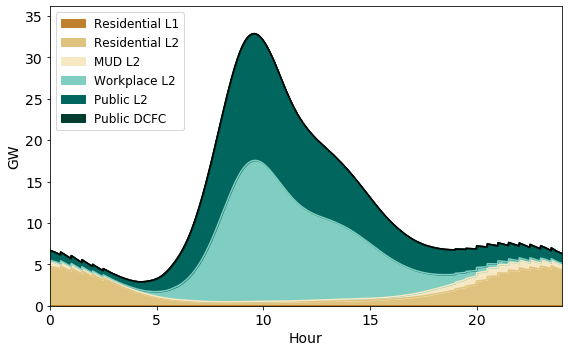

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


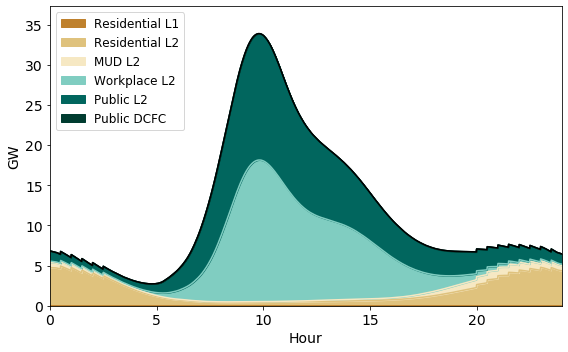

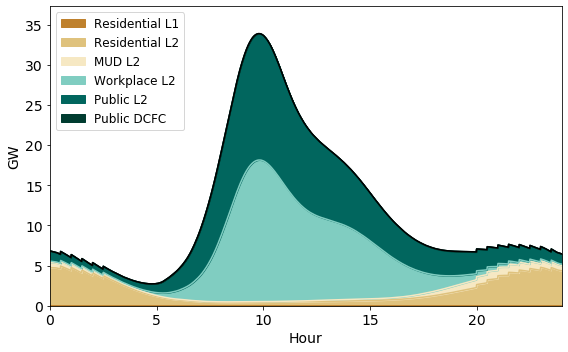

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


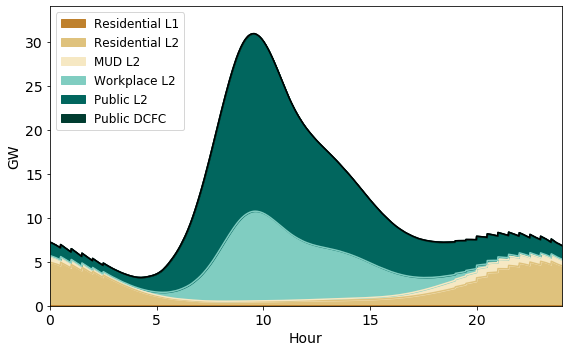

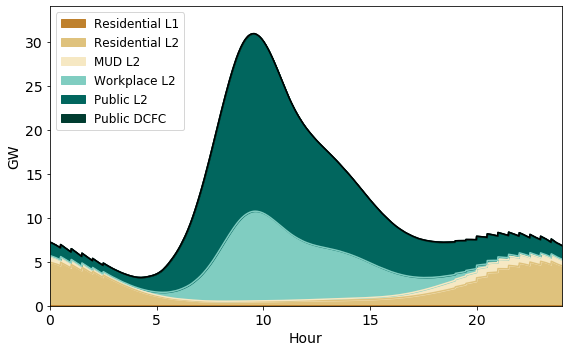

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


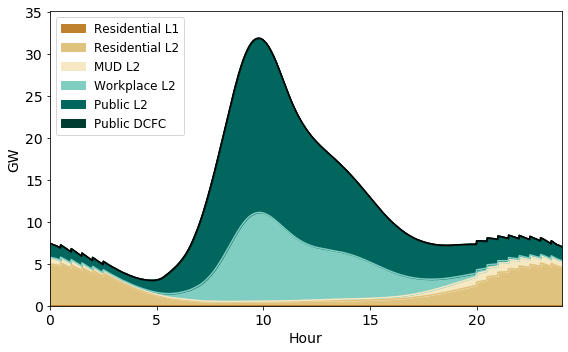

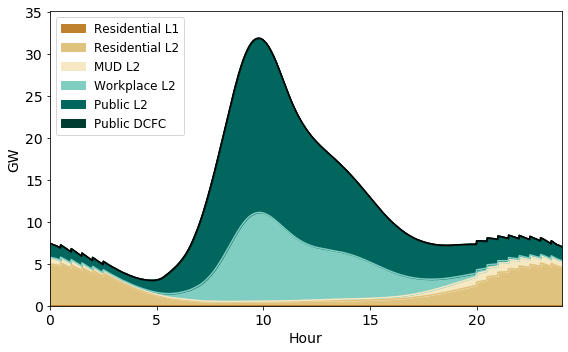

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


In [37]:
for access in ['HighHome', 'UniversalHome', 'LowHome_HighWork', 'LowHome_LowWork']:
    run_100p_wecc(access, False, 'Mixed', access+'_100p_RandomTimers', '20220313', tz_aware=True)
    run_100p_wecc(access, False, 'Mixed', access+'_100p_RandomTimers', '20211119', tz_aware=False)

----------OR----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


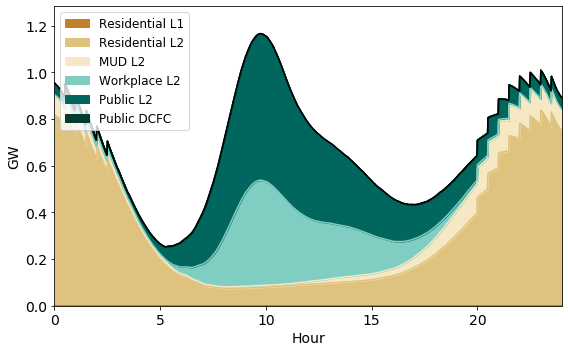

In [4]:
state = 'OR'; scenario_name = 'HighHome'; remove_timers=False; utility_region='Mixed'; 
print('----------'+state+'----------')
data = DataSetConfigurations(data_set='CP')
speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
speech.pa_ih(scenario=scenario_name) # define the access scenario
speech.pg_multiple_regions(region_type='State', region_value_list=[state])
config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
config.run_all(verbose=False, weekday='weekday')
plot(config.total_load_segments, config.total_load_dict, data)

----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


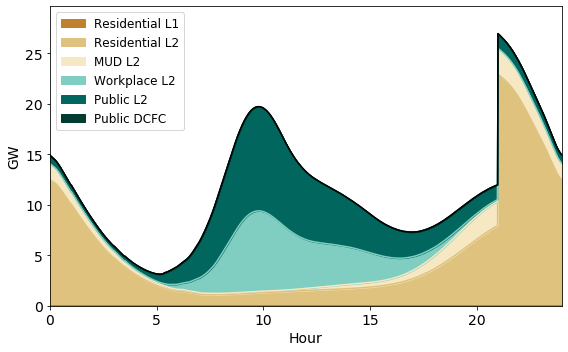

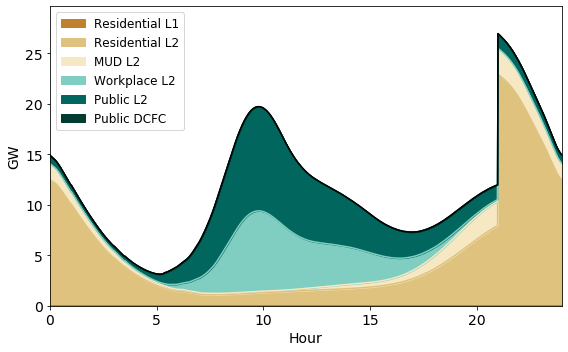

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
Time for first scenario full run:  531.2253859043121
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


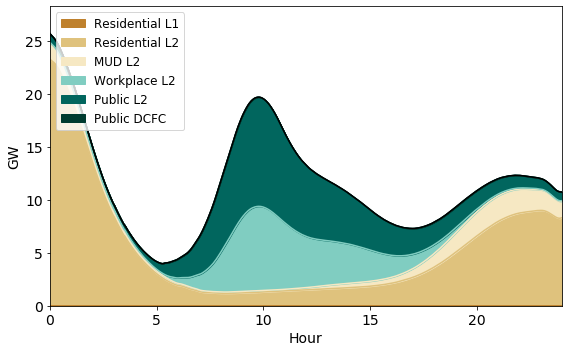

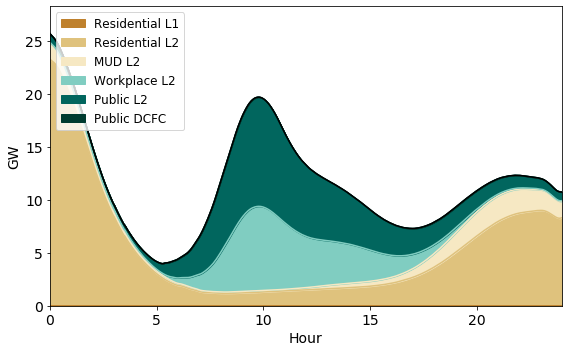

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


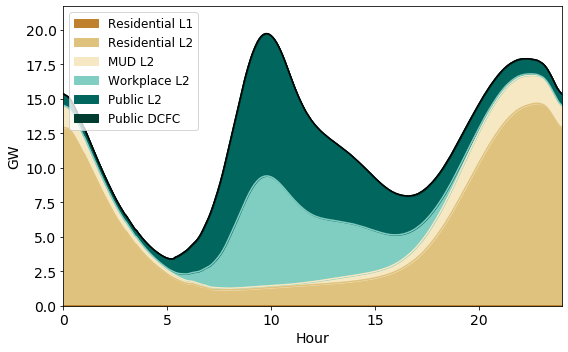

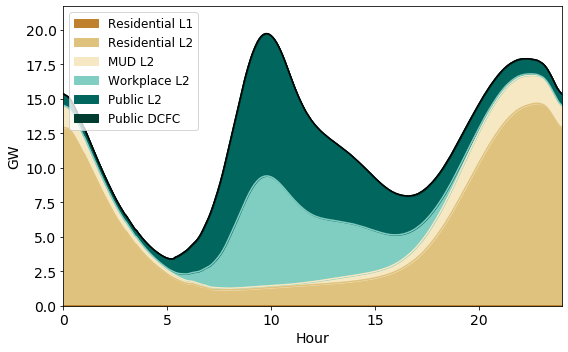

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


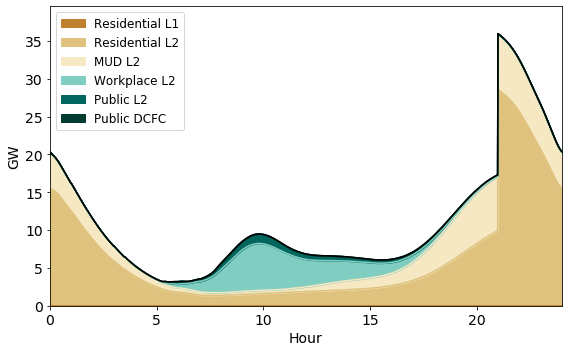

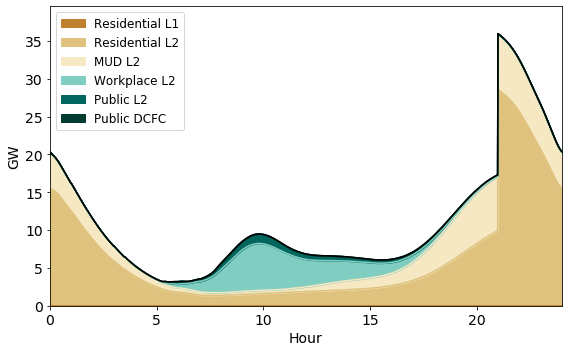

Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


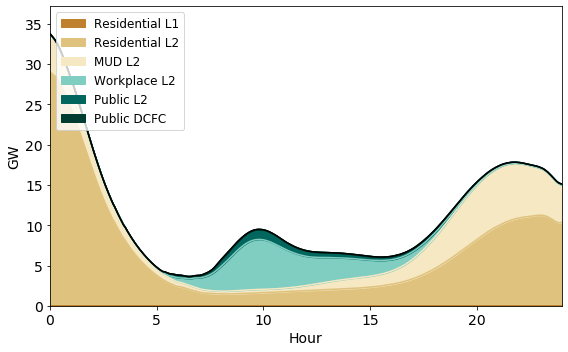

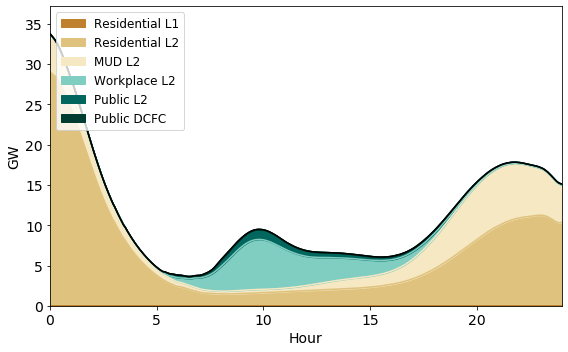

Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


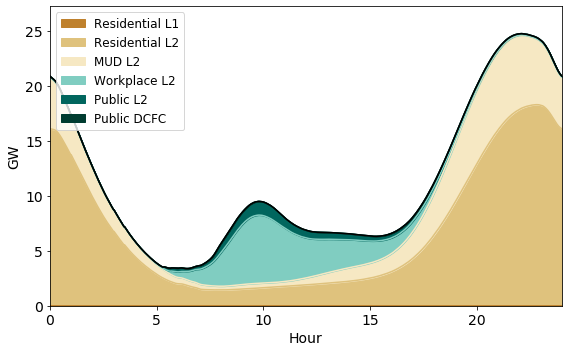

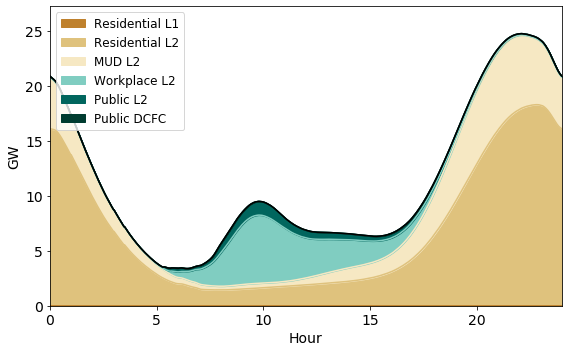

Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


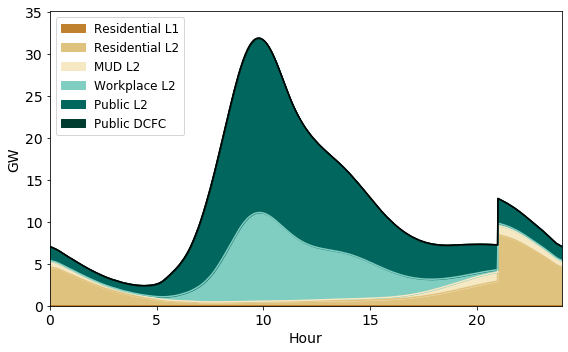

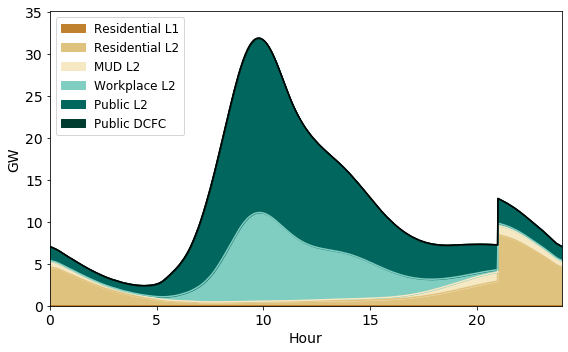

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


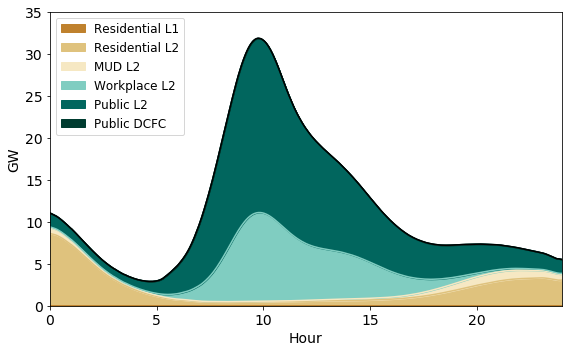

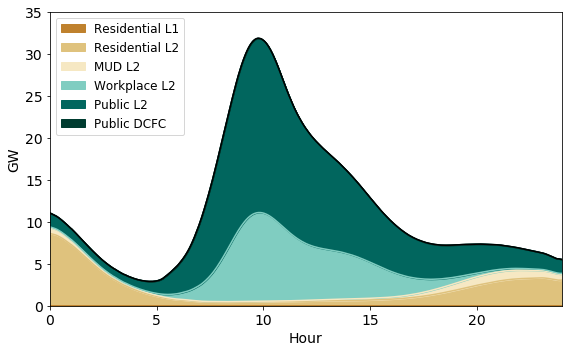

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


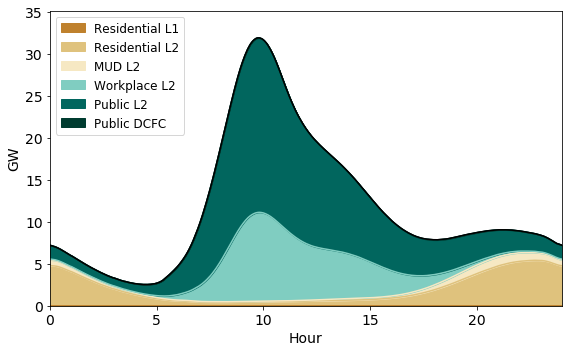

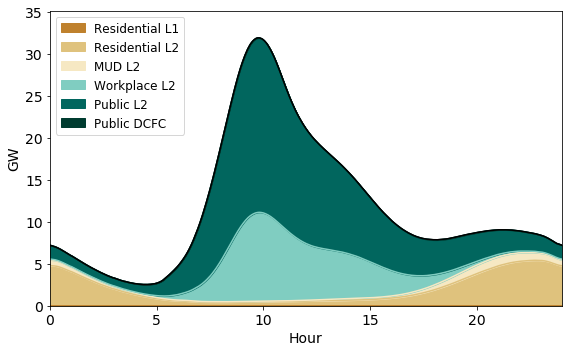

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


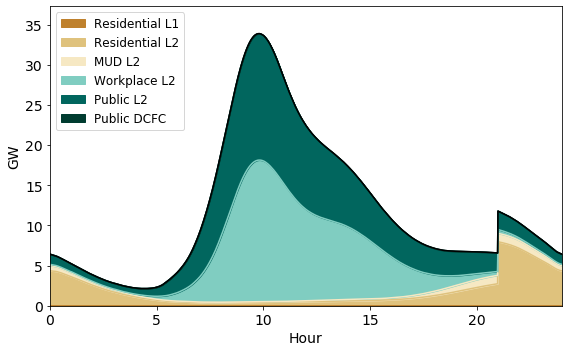

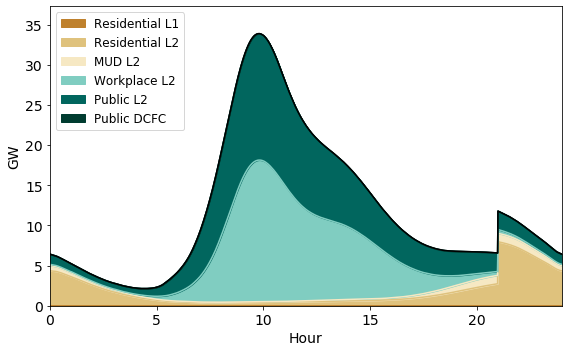

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


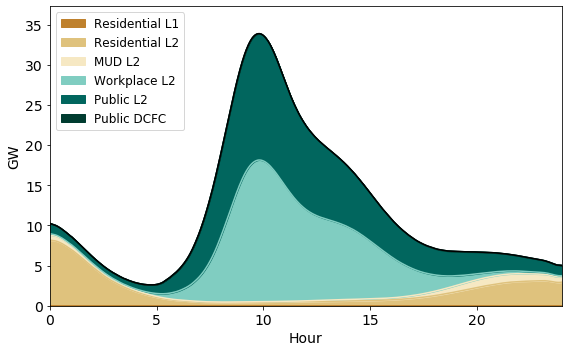

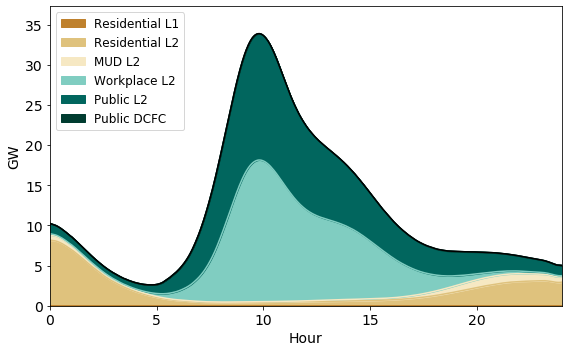

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


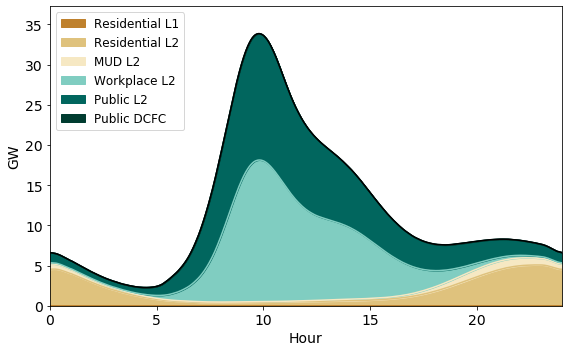

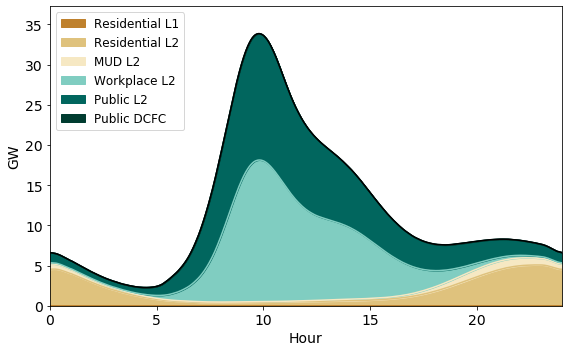

Total EVs in WECC:  48640772
----------CA----------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941


In [6]:
date = '20211119'
tic = time.time()
run_100p_wecc('HighHome', False, 'SCE', 'HighHome_100p', date)
toc = time.time()
print('Time for first scenario full run: ', toc-tic)
run_100p_wecc('HighHome', False, 'SDGE', 'HighHome_100p_midnighttimer', date)
run_100p_wecc('HighHome', True, 'SDGE', 'HighHome_100p_NoTimers', date)
run_100p_wecc('UniversalHome', False, 'SCE', 'UniversalHome_100p', date)
run_100p_wecc('UniversalHome', False, 'SDGE', 'UniversalHome_100p_midnighttimer', date)
run_100p_wecc('UniversalHome', True, 'PGE', 'UniversalHome_100p_NoTimers', date)
run_100p_wecc('LowHome_LowWork', False, 'SCE', 'LowHome_LowWork_100p', date)
run_100p_wecc('LowHome_LowWork', False, 'SDGE', 'LowHome_LowWork_100p_midnighttimer', date)
run_100p_wecc('LowHome_LowWork', True, 'PGE', 'LowHome_LowWork_100p_NoTimers', date)
run_100p_wecc('LowHome_HighWork', False, 'SCE', 'LowHome_HighWork_100p', date)
run_100p_wecc('LowHome_HighWork', False, 'SDGE', 'LowHome_HighWork_100p_midnighttimer', date)
run_100p_wecc('LowHome_HighWork', True, 'PGE', 'LowHome_HighWork_100p_NoTimers', date)

# Business As Usual Case

In [10]:
# load population data from main model
state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
data = DataSetConfigurations(data_set='CP')
speech_test = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=state_list)

speech_test.pdih_data = pd.read_csv(speech_test.data.folder + 'pdih_us_counties.csv', index_col=0)
pop_dict = {state: speech_test.pdih_data[speech_test.pdih_data['State'] == state]['# Total Population, 2019 [Estimated]'].sum() for state in state_list}

In [11]:
sce_counties = ['San Bernardino County, CA', 'Riverside County, CA', 
                'Orange County, CA', 'Los Angeles County, CA', 
                'Ventura County, CA', 'Santa Barbara County, CA', 
                'Kern County, CA', 'Tulare County, CA', 
                'Inyo County, CA', 'Mono County, CA', 
                'Fresno County, CA', 'Kings County, CA', 'Tuolumne County, CA']
not_sce_counties = ['Alameda County, CA', 'Alpine County, CA', 'Amador County, CA',
       'Butte County, CA', 'Calaveras County, CA', 'Colusa County, CA',
       'Contra Costa County, CA', 'Del Norte County, CA',
       'El Dorado County, CA', 'Glenn County, CA',
       'Humboldt County, CA', 'Imperial County, CA', 
       'Lake County, CA',
       'Lassen County, CA', 'Madera County, CA',
       'Marin County, CA', 'Mariposa County, CA', 'Mendocino County, CA',
       'Merced County, CA', 'Modoc County, CA', 
       'Monterey County, CA', 'Napa County, CA', 'Nevada County, CA',
       'Placer County, CA', 'Plumas County, CA',
       'Sacramento County, CA',
       'San Benito County, CA', 
       'San Diego County, CA', 'San Francisco County, CA',
       'San Joaquin County, CA', 'San Luis Obispo County, CA',
       'San Mateo County, CA', 
       'Santa Clara County, CA', 'Santa Cruz County, CA',
       'Shasta County, CA', 'Sierra County, CA', 'Siskiyou County, CA',
       'Solano County, CA', 'Sonoma County, CA', 'Stanislaus County, CA',
       'Sutter County, CA', 'Tehama County, CA', 'Trinity County, CA',
       'Yolo County, CA', 'Yuba County, CA']

In [12]:
print(len(sce_counties) + len(not_sce_counties))

58


In [14]:
# sce counties makes up approximately 55% of CA population
speech_test.pdih_data[speech_test.pdih_data.Name.isin(sce_counties)]['# Total Population, 2019 [Estimated]'].sum() / speech_test.pdih_data[speech_test.pdih_data.State=='CA']['# Total Population, 2019 [Estimated]'].sum()

0.5516638358342496

Open EI Utility database: 

- Utah Pacificorp 8pm
- Portland Gas & Electric 10pm
- PG&E 12am
- SCE 9pm
- SDGE 12am

Then assign others to match rough distribution of California timers


In [15]:
# midnight timers = 45% of CA + all of WA, ID, MT, WY, NV 
print((0.45 * pop_dict['CA'] + pop_dict['WA'] + pop_dict['ID'] + pop_dict['MT'] + pop_dict['WY'] + pop_dict['NV']) / int(sum(pop_dict.values())))

# 9pm = 55% of CA (SCE) + all of CO, NM, AZ
print((0.55 * pop_dict['CA'] + pop_dict['CO'] + pop_dict['NM'] + pop_dict['AZ']) / int(sum(pop_dict.values())))

# OR at 10pm
print(pop_dict['OR'] / int(sum(pop_dict.values())))

# UT at 8pm
print(pop_dict['UT'] / int(sum(pop_dict.values())))

0.4187899286017748
0.4851885413905939
0.054877280554671386
0.04114424945295988


## run scenario: 

----------CA2----------
Utility region:  SCE
Total EVs:  12842677
----------CA1----------
Utility region:  SDGE
Total EVs:  11392155
----------OR----------
Utility region:  Portland
Total EVs:  2923172
----------WA----------
Utility region:  SDGE
Total EVs:  5280998
----------ID----------
Utility region:  SDGE
Total EVs:  1269502
----------MT----------
Utility region:  SDGE
Total EVs:  863108
----------WY----------
Utility region:  SDGE
Total EVs:  478703
----------NV----------
Utility region:  SDGE
Total EVs:  1879178
----------UT----------
Utility region:  Utah
Total EVs:  1951222
----------CO----------
Utility region:  SCE
Total EVs:  3977177
----------NM----------
Utility region:  SCE
Total EVs:  1407939
----------AZ----------
Utility region:  SCE
Total EVs:  4374941


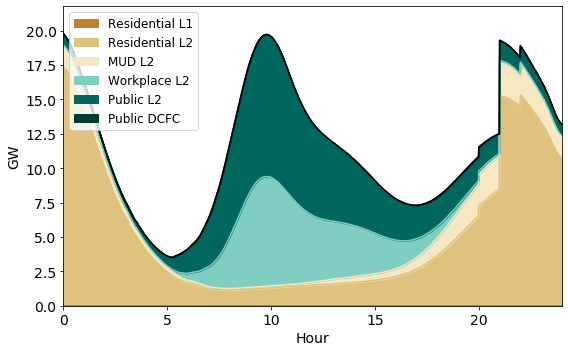

Total EVs in WECC:  48640772
----------CA2----------
Utility region:  SCE


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  12842677
----------CA1----------
Utility region:  SDGE
Total EVs:  11392155
----------OR----------
Utility region:  Portland
Total EVs:  2923172
----------WA----------
Utility region:  SDGE
Total EVs:  5280998
----------ID----------
Utility region:  SDGE
Total EVs:  1269502
----------MT----------
Utility region:  SDGE
Total EVs:  863108
----------WY----------
Utility region:  SDGE
Total EVs:  478703
----------NV----------
Utility region:  SDGE
Total EVs:  1879178
----------UT----------
Utility region:  Utah
Total EVs:  1951222
----------CO----------
Utility region:  SCE
Total EVs:  3977177
----------NM----------
Utility region:  SCE
Total EVs:  1407939
----------AZ----------
Utility region:  SCE
Total EVs:  4374941


In [16]:
scenario_name = 'BusinessAsUsual'
date = '20211119'
save_string = 'BusinessAsUsual_100p'
remove_timers = False

state_utility_map = {'CA1':'SDGE', 'CA2':'SCE', 'OR':'Portland', 'UT':'Utah', 'WA':'SDGE', 
                     'ID':'SDGE', 'MT':'SDGE', 'NV':'SDGE', 'WY':'SDGE', 'CO':'SCE', 'NM':'SCE', 'AZ':'SCE'}
    
wecc_tot_evs = 0
state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
state_results = {}
total_load_dict = {key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']}
total_load_segments = np.zeros((1440, 6))
for state in state_list:
    if state == 'CA':
        print('----------'+'CA2'+'----------')
        utility_region = state_utility_map['CA2']
        print('Utility region: ', utility_region)
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario='HighHome')
        speech.pg_multiple_regions(region_type='Name', region_value_list=sce_counties) # SCE Counties
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekday')
        state_results[state] = {'Speech':speech, 'Config':config}
        for key in total_load_dict.keys():
            total_load_dict[key] += config.total_load_dict[key]
        total_load_segments += config.total_load_segments
        print('Total EVs: ', config.num_total_drivers)
        wecc_tot_evs += config.num_total_drivers

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_'+'CA2'+'_'+date+'.csv')
        
        
        print('----------'+'CA1'+'----------')
        utility_region = state_utility_map['CA1']
        print('Utility region: ', utility_region)
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario='HighHome')
        speech.pg_multiple_regions(region_type='Name', region_value_list=not_sce_counties) # Not SCE Counties
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekday')
        state_results[state] = {'Speech':speech, 'Config':config}
        for key in total_load_dict.keys():
            total_load_dict[key] += config.total_load_dict[key]
        total_load_segments += config.total_load_segments
        print('Total EVs: ', config.num_total_drivers)
        wecc_tot_evs += config.num_total_drivers

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_'+'CA1'+'_'+date+'.csv')
        
        
    else:
        print('----------'+state+'----------')
        utility_region = state_utility_map[state]
        print('Utility region: ', utility_region)
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario='HighHome')
        speech.pg_multiple_regions(region_type='State', region_value_list=[state])
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekday')
        state_results[state] = {'Speech':speech, 'Config':config}
        for key in total_load_dict.keys():
            total_load_dict[key] += config.total_load_dict[key]
        total_load_segments += config.total_load_segments
        print('Total EVs: ', config.num_total_drivers)
        wecc_tot_evs += config.num_total_drivers

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_'+str(state)+'_'+date+'.csv')
pd.DataFrame(total_load_dict).to_csv('Outputs/'+save_string+'_WECC_'+date+'.csv')

try:
    plot(total_load_segments, total_load_dict, data, 'Outputs/'+save_string+'_WECC_'+date+'.pdf')
except:
    print('Error in plotting.')
print('Total EVs in WECC: ', wecc_tot_evs)


state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
state_results = {}
total_load_dict = {key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']}
total_load_segments = np.zeros((1440, 6))
for state in state_list:
    if state == 'CA':
        
        print('----------'+'CA2'+'----------')
        utility_region = state_utility_map['CA2']
        print('Utility region: ', utility_region)
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario='HighHome')
        speech.pg_multiple_regions(region_type='Name', region_value_list=sce_counties)
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekend')
        state_results[state] = {'Speech':speech, 'Config':config}
        for key in total_load_dict.keys():
            total_load_dict[key] += config.total_load_dict[key]
        total_load_segments += config.total_load_segments
        print('Total EVs: ', config.num_total_drivers)

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_weekend_'+'CA2'+'_'+date+'.csv')
        
        print('----------'+'CA1'+'----------')
        utility_region = state_utility_map['CA1']
        print('Utility region: ', utility_region)
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario='HighHome')
        speech.pg_multiple_regions(region_type='Name', region_value_list=not_sce_counties)
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekend')
        state_results[state] = {'Speech':speech, 'Config':config}
        for key in total_load_dict.keys():
            total_load_dict[key] += config.total_load_dict[key]
        total_load_segments += config.total_load_segments
        print('Total EVs: ', config.num_total_drivers)

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_weekend_'+'CA1'+'_'+date+'.csv')
        
    else:
        print('----------'+state+'----------')
        utility_region = state_utility_map[state]
        print('Utility region: ', utility_region)
        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario='HighHome')
        speech.pg_multiple_regions(region_type='State', region_value_list=[state])
        config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
        config.run_all(verbose=False, weekday='weekend')
        state_results[state] = {'Speech':speech, 'Config':config}
        for key in total_load_dict.keys():
            total_load_dict[key] += config.total_load_dict[key]
        total_load_segments += config.total_load_segments
        print('Total EVs: ', config.num_total_drivers)

        pd.DataFrame(config.total_load_dict).to_csv('Outputs/'+save_string+'_weekend_'+str(state)+'_'+date+'.csv')
        
pd.DataFrame(total_load_dict).to_csv('Outputs/'+save_string+'_weekend_WECC_'+date+'.csv')
    

## adjust timezones

In [34]:

load_date = '20211119'
save_date = '20220313'
state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
state_list_BAU = ['CA1', 'CA2', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
time_zones = {'CA':0, 'CA1':0, 'CA2':0, 'OR':0, 'WA':0, 'ID':1, 'MT':1, 'WY':1, 'NV':0, 'UT':1, 'CO':1, 'NM':1, 'AZ':1}

for save_string in ['HighHome_100p_midnighttimer', 'HighHome_100p', 'HighHome_100p_NoTimers', 'UniversalHome_100p', 'UniversalHome_100p_midnighttimer', 'UniversalHome_100p_NoTimers', 'LowHome_LowWork_100p', 'LowHome_LowWork_100p_midnighttimer', 'LowHome_LowWork_100p_NoTimers', 'LowHome_HighWork_100p', 'LowHome_HighWork_100p_midnighttimer', 'LowHome_HighWork_100p_NoTimers']:
    for weekday in ['', '_weekend']:
        state_results = {}
        total_load_dict = pd.DataFrame({key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']})
        for state in state_list:
            config_total_load_dict = pd.read_csv('Outputs/'+save_string+weekday+'_'+str(state)+'_'+load_date+'.csv', index_col=0)
            if time_zones[state] == 1:
                tmp = pd.DataFrame(config_total_load_dict).copy(deep=True)
                tmp2 = 0*tmp.copy(deep=True)
                tmp2.loc[np.arange(0, 1440-60), :] = tmp.loc[np.arange(60, 1440), :].values
                tmp2.loc[np.arange(1440-60, 1440), :] = tmp.loc[np.arange(0, 60), :].values
                total_load_dict += tmp2
            else:
                total_load_dict += config_total_load_dict
        total_load_dict.to_csv('Outputs/'+save_string+weekday+'_WECC_'+save_date+'.csv')
        
save_string = 'BusinessAsUsual_100p'
for weekday in ['', '_weekend']:
    state_results = {}
    total_load_dict = pd.DataFrame({key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']})
    for state in state_list_BAU:
        config_total_load_dict = pd.read_csv('Outputs/'+save_string+weekday+'_'+str(state)+'_'+load_date+'.csv', index_col=0)
        if time_zones[state] == 1:
            tmp = pd.DataFrame(config_total_load_dict).copy(deep=True)
            tmp2 = 0*tmp.copy(deep=True)
            tmp2.loc[np.arange(0, 1440-60), :] = tmp.loc[np.arange(60, 1440), :].values
            tmp2.loc[np.arange(1440-60, 1440), :] = tmp.loc[np.arange(0, 60), :].values
            total_load_dict += tmp2
        else:
            total_load_dict += config_total_load_dict
    total_load_dict.to_csv('Outputs/'+save_string+weekday+'_WECC_'+save_date+'.csv')



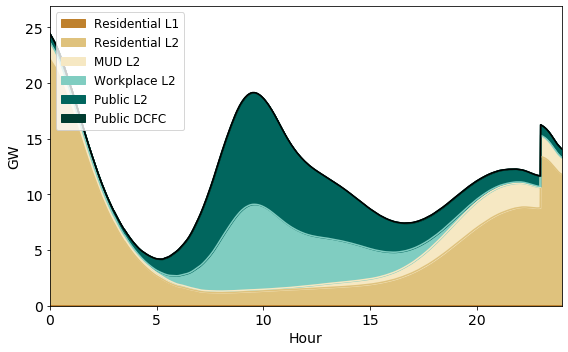

In [27]:
total_load_dict = pd.read_csv('Outputs/HighHome_100p_midnighttimer_WECC_'+save_date+'.csv', index_col=0)
plot(total_load_dict.values, total_load_dict, data)

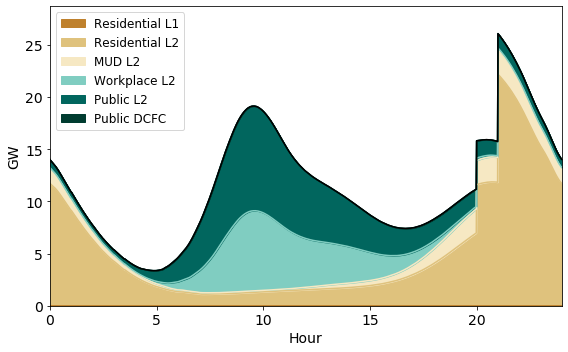

In [30]:
total_load_dict = pd.read_csv('Outputs/HighHome_100p_WECC_'+save_date+'.csv', index_col=0)
plot(total_load_dict.values, total_load_dict, data)

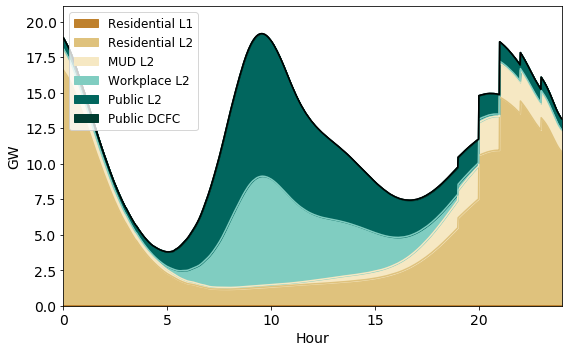

In [35]:
total_load_dict = pd.read_csv('Outputs/BusinessAsUsual_100p_WECC_'+save_date+'.csv', index_col=0)
plot(total_load_dict.values, total_load_dict, data)